<a href="https://colab.research.google.com/github/konstantin-12345/unifed-experiments/blob/main/%E5%A4%A7%E6%95%B0%E6%8D%AE%E9%9B%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 安装必要的依赖包
!pip install torch torchvision tqdm matplotlib seaborn pandas torchtext nltk

In [2]:
from sklearn.metrics import precision_score
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, random_split
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import random
import os
from tqdm.notebook import tqdm
from collections import defaultdict
import math
import gc
import copy
import torch, numpy as np, random
import matplotlib.pyplot as plt
# 以及你已有的 from torch...，prepare_dataset, UniFedClient, UniFedServer, run_unifed, FEMNISTModel...


# 设置随机种子确保可重复性
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 检查GPU可用性
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 增加内存回收辅助函数
def clear_memory():
    """清理GPU和CPU内存"""
    gc.collect()
    torch.cuda.empty_cache()

使用设备: cuda:0


In [3]:
# 增加内存回收辅助函数
def clear_memory():
    """清理GPU和CPU内存"""
    gc.collect()
    torch.cuda.empty_cache()

# 1. 模型定义 - 分别为CV和NLP任务定义模型
class SimpleConvNet(nn.Module):
    """简单CNN模型用于CIFAR-10/100"""
    def __init__(self, num_classes=10, input_channels=3):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class FEMNISTModel(nn.Module):
    """用于FEMNIST数据集的模型"""
    def __init__(self, num_classes=62):
        super(FEMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class TextModel(nn.Module):
    """用于NLP任务的简单模型"""
    def __init__(self, vocab_size, embed_dim=50, hidden_dim=100, num_classes=4):
        super(TextModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x的形状: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim]
        # 取最后一个时间步的输出
        out = lstm_out[:, -1, :]  # [batch_size, hidden_dim]
        return self.fc(out)  # [batch_size, num_classes]

In [4]:
# 2. 数据集准备函数
def prepare_dataset(dataset_name, num_clients, alpha=0.5, root_dir='./data'):
    """
    准备不同数据集并按非IID方式分配

    参数:
    - dataset_name: 数据集名称 ('cifar10', 'cifar100', 'femnist', 'shakespeare', 'agnews')
    - num_clients: 客户端数量
    - alpha: Dirichlet分布的参数，控制非IID程度

    返回:
    - client_datasets: 客户端数据集列表
    - test_dataset: 测试数据集
    - input_shape: 输入形状
    - num_classes: 类别数
    """
    if dataset_name == 'cifar10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = torchvision.datasets.CIFAR10(
            root=root_dir, train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(
            root=root_dir, train=False, download=True, transform=transform)
        num_classes = 10
        input_shape = (3, 32, 32)  # CIFAR-10是3通道32x32图像
        return split_dataset_noniid(train_dataset, test_dataset, num_clients, num_classes, alpha), input_shape, num_classes

    elif dataset_name == 'cifar100':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = torchvision.datasets.CIFAR100(
            root=root_dir, train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR100(
            root=root_dir, train=False, download=True, transform=transform)
        num_classes = 100
        input_shape = (3, 32, 32)
        return split_dataset_noniid(train_dataset, test_dataset, num_clients, num_classes, alpha), input_shape, num_classes

    # 其他数据集的处理可以在这里添加
    # 由于复杂度，这里只模拟FEMNIST、Shakespeare和AG News的数据加载
    # 实际应用中应当实现完整的数据集加载逻辑

    elif dataset_name == 'femnist':
        # 简化的FEMNIST模拟
        print("加载模拟FEMNIST数据集...")
        # 实际应从Leaf项目加载真实FEMNIST数据集
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        # 用MNIST代替FEMNIST进行模拟
        train_dataset = torchvision.datasets.MNIST(
            root=root_dir, train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(
            root=root_dir, train=False, download=True, transform=transform)
        num_classes = 10  # 实际FEMNIST有62类
        input_shape = (1, 28, 28)
        return split_dataset_noniid(train_dataset, test_dataset, num_clients, num_classes, alpha), input_shape, num_classes

    elif dataset_name in ['shakespeare', 'agnews']:
        # 为NLP任务创建简化模拟数据集
        print(f"加载模拟{dataset_name}数据集...")
        # 这里简化处理，实际应加载真实数据集
        num_samples = 1000
        seq_length = 50
        vocab_size = 5000

        # 创建随机数据
        X = torch.randint(0, vocab_size, (num_samples, seq_length))
        if dataset_name == 'shakespeare':
            # 假设为字符预测任务
            y = torch.randint(0, vocab_size, (num_samples,))
            num_classes = vocab_size
        else:  # agnews
            # 假设为文本分类任务
            y = torch.randint(0, 4, (num_samples,))  # AG News有4个类别
            num_classes = 4

        # 创建简单数据集
        dummy_dataset = DummyDataset(X, y)

        # 分割为训练集和测试集
        train_size = int(0.8 * len(dummy_dataset))
        test_size = len(dummy_dataset) - train_size
        train_dataset, test_dataset = random_split(dummy_dataset, [train_size, test_size])

        # 非IID划分
        client_datasets = []
        data_per_client = train_size // num_clients
        for i in range(num_clients):
            start_idx = i * data_per_client
            end_idx = min((i + 1) * data_per_client, train_size)
            indices = list(range(start_idx, end_idx))
            client_datasets.append(Subset(train_dataset, indices))

        input_shape = (seq_length,)
        return (client_datasets, test_dataset), input_shape, num_classes

    else:
        raise ValueError(f"不支持的数据集: {dataset_name}")

# 辅助类：模拟NLP数据集
class DummyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def split_dataset_noniid(train_dataset, test_dataset, num_clients, num_classes, alpha=0.5):
    """使用Dirichlet分布进行非IID数据划分"""
    # 提取标签
    if hasattr(train_dataset, 'targets'):
        labels = np.array(train_dataset.targets)
    elif hasattr(train_dataset, 'train_labels'):
        labels = np.array(train_dataset.train_labels)
    else:
        # 尝试从数据集中提取标签
        labels = np.array([y for _, y in [train_dataset[i] for i in range(len(train_dataset))]])

    # 按类别划分索引
    client_indices = [[] for _ in range(num_clients)]

    # 使用Dirichlet分布生成非IID分配
    label_distribution = np.random.dirichlet([alpha] * num_clients, num_classes)

    for c in range(num_classes):
        idx_c = np.where(labels == c)[0]
        np.random.shuffle(idx_c)

        # 计算累积比例
        proportions = label_distribution[c]
        proportions = proportions / proportions.sum()
        cumulative = np.cumsum(proportions)

        # 分配给各客户端
        for i in range(num_clients):
            if i < num_clients - 1:
                idx_i = idx_c[int(cumulative[i] * len(idx_c)):int(cumulative[i+1] * len(idx_c))]
            else:
                idx_i = idx_c[int(cumulative[i-1] * len(idx_c)):]
            client_indices[i].extend(idx_i.tolist())

    # 创建客户端数据集
    client_datasets = []
    for indices in client_indices:
        client_datasets.append(Subset(train_dataset, indices))

    return client_datasets, test_dataset
# 3. 资源配置生成函数
def generate_heterogeneous_resources(num_clients, strategy='grouped'):
    """
    生成异构客户端资源配置

    参数:
    - num_clients: 客户端数量
    - strategy: 生成策略，'grouped'表示按分组生成，'random'表示随机生成

    返回:
    - list of dicts: 每个客户端的资源配置
    """
    if strategy == 'grouped':
        # 按照要求的比例分组
        high_count = int(0.2 * num_clients)  # 20%高资源组
        mid_count = int(0.4 * num_clients)   # 40%中资源组
        low_count = int(0.35 * num_clients)  # 35%低资源组
        very_low_count = num_clients - high_count - mid_count - low_count  # 剩余为极低资源组

        client_resources = []

        # 高资源组: RCI ∈ [0.8, 1.0]
        for i in range(high_count):
            rci_value = np.random.uniform(0.8, 1.0)
            # 反向计算各资源值以匹配目标RCI (简化版)
            base_value = rci_value
            client_resources.append({
                'id': i,
                'computational_power': np.random.uniform(0.8, 1.0),
                'memory_availability': np.random.uniform(0.8, 1.0),
                'energy_efficiency': np.random.uniform(0.0, 0.2),  # 能耗，低值更好
                'bandwidth': np.random.uniform(0.8, 1.0),
                'group': 'high'
            })

        # 中资源组: RCI ∈ [0.4, 0.8]
        for i in range(high_count, high_count + mid_count):
            rci_value = np.random.uniform(0.4, 0.8)
            client_resources.append({
                'id': i,
                'computational_power': np.random.uniform(0.4, 0.8),
                'memory_availability': np.random.uniform(0.4, 0.8),
                'energy_efficiency': np.random.uniform(0.2, 0.6),
                'bandwidth': np.random.uniform(0.4, 0.8),
                'group': 'medium'
            })

        # 低资源组: RCI ∈ [0.1, 0.4]
        for i in range(high_count + mid_count, high_count + mid_count + low_count):
            rci_value = np.random.uniform(0.1, 0.4)
            client_resources.append({
                'id': i,
                'computational_power': np.random.uniform(0.1, 0.4),
                'memory_availability': np.random.uniform(0.1, 0.4),
                'energy_efficiency': np.random.uniform(0.6, 0.9),
                'bandwidth': np.random.uniform(0.1, 0.4),
                'group': 'low'
            })

        # 极低资源组: RCI ∈ [0.05, 0.1]
        for i in range(high_count + mid_count + low_count, num_clients):
            rci_value = np.random.uniform(0.05, 0.1)
            client_resources.append({
                'id': i,
                'computational_power': np.random.uniform(0.05, 0.1),
                'memory_availability': np.random.uniform(0.05, 0.1),
                'energy_efficiency': np.random.uniform(0.9, 0.95),
                'bandwidth': np.random.uniform(0.05, 0.1),
                'group': 'very_low'
            })

    else:  # random
        # 随机生成资源配置
        client_resources = []
        for i in range(num_clients):
            comp = np.random.uniform(0.05, 1.0)
            mem = np.random.uniform(0.05, 1.0)
            energy = np.random.uniform(0.0, 0.95)  # 能耗，低值更好
            bw = np.random.uniform(0.05, 1.0)

            # 确定组别
            rci_value = 0.25 * (comp + mem + (1-energy) + bw)  # 简化计算
            if rci_value >= 0.8:
                group = 'high'
            elif rci_value >= 0.4:
                group = 'medium'
            elif rci_value >= 0.1:
                group = 'low'
            else:
                group = 'very_low'

            client_resources.append({
                'id': i,
                'computational_power': comp,
                'memory_availability': mem,
                'energy_efficiency': energy,
                'bandwidth': bw,
                'group': group
            })

    return client_resources

In [5]:
# 4. UniFed客户端实现
class UniFedClient:
    #def __init__(self, client_id, dataset, model, resource_profile=None, is_nlp=False):
    def __init__(self, client_id, dataset, model, resource_profile=None, is_nlp=False, mu=0.0):
        self.client_id = client_id
        self.dataset = dataset
        self.model = copy.deepcopy(model)
        self.resource_profile = resource_profile or {}
        self.group = resource_profile.get('group', 'unknown') if resource_profile else 'unknown'
        self.batch_size = max(4, int(32 * self.resource_profile.get('memory_availability', 0.5)))
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        self.selected_times = 0
        self.device = device
        self.is_nlp = is_nlp
        self.mu = mu

        # 节省内存：仅在需要时将模型移动到设备
        self.model_on_device = False


        # 优化器
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        self.criterion = nn.CrossEntropyLoss()

    def to_device(self):
        """将模型移动到设备"""
        if not self.model_on_device:
            self.model.to(self.device)
            self.model_on_device = True

    def to_cpu(self):
        """将模型移回CPU以节省GPU内存"""
        if self.model_on_device:
            self.model.to('cpu')
            self.model_on_device = False

    def calculate_rci(self, lambda_weights=(0.25, 0.25, 0.25, 0.25)):
        """计算资源复合指数"""
        # 使用资源配置文件中的数据
        comp = self.resource_profile.get('computational_power', 0.5)
        mem = self.resource_profile.get('memory_availability', 0.5)
        energy = self.resource_profile.get('energy_efficiency', 0.5)  # 注意这里是能耗，越低越好
        bw = self.resource_profile.get('bandwidth', 0.5)

        # 计算RCI
        rci = (
            lambda_weights[0] * comp +
            lambda_weights[1] * mem +
            lambda_weights[2] * (1 - energy) +  # 能耗越低越好，所以用1-energy
            lambda_weights[3] * bw
        )

        return rci

    def train(self, global_model, num_epochs, distill_labels=None):
        """本地训练"""
        import copy
        global_state_dict = copy.deepcopy(global_model.state_dict())
        # 将模型移动到设备
        self.to_device()

        # 从全局模型初始化
        self.model.load_state_dict(copy.deepcopy(global_model.state_dict()))
        initial_state = copy.deepcopy(global_model.state_dict())

        self.model.train()
        epoch_losses = []

        # 根据资源限制调整本地训练轮数
        rci = self.calculate_rci()

        #actual_epochs = max(1, int(num_epochs * rci))
        # 改为：min_e=1, max_e=5，弱设备少跑，强设备多跑
        min_e, max_e = 1, 5
        actual_epochs = min(max(int(num_epochs * rci), min_e), max_e)



        # 计算能耗比率 (模拟)
        energy_efficiency = self.resource_profile.get('energy_efficiency', 0.5)
        energy_consumed = actual_epochs * (1 + energy_efficiency)  # 模拟能耗

        for epoch in range(actual_epochs):
            running_loss = 0.0
            for inputs, targets in self.dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # 前向传播
                self.optimizer.zero_grad()
                outputs = self.model(inputs)

                loss = self.criterion(outputs, targets)

               # FedProx 正则
                mu = self.mu
                prox_term = 0
                for name, param in self.model.named_parameters():
                  w_glob = global_state_dict[name].to(self.device)
                  prox_term += torch.norm(param - w_glob)**2
                loss += (mu / 2) * prox_term


                # 如果有蒸馏标签，添加蒸馏损失
                if distill_labels is not None and not self.is_nlp:
                    # 获取与输入相同形状的蒸馏标签
                    batch_idx = np.random.choice(len(distill_labels), inputs.size(0))
                    batch_distill = distill_labels[batch_idx].to(self.device)

                    # 计算蒸馏损失 (KL散度)
                    T = 2.0  # 温度参数
                    distill_outputs = F.softmax(outputs / T, dim=1)
                    distill_targets = F.softmax(batch_distill / T, dim=1)
                    distill_loss = nn.KLDivLoss(reduction='batchmean')(
                        F.log_softmax(outputs / T, dim=1),
                        distill_targets
                    ) * (T * T)

                    # 结合损失 (alpha=0.5平衡原始损失和蒸馏损失)
                    loss = 0.5 * loss + 0.5 * distill_loss

                # 反向传播
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(self.dataloader)
            epoch_losses.append(epoch_loss)

        # 生成软标签（蒸馏信息）- 使用固定数量的样本
        self.model.eval()
        max_samples = min(100, len(self.dataset))  # 限制样本数量
        logits_list = []
        sample_count = 0

        with torch.no_grad():
            for inputs, _ in self.dataloader:
                if sample_count >= max_samples:
                    break
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                logits_list.append(outputs)
                sample_count += inputs.size(0)

        if logits_list:
            all_logits = torch.cat(logits_list, dim=0)[:max_samples]
            soft_labels = F.softmax(all_logits / 2.0, dim=1)  # 温度为2
        else:
            soft_labels = None

        # 计算与初始模型的梯度差异
        gradients = {}
        for key in self.model.state_dict().keys():
            gradients[key] = self.model.state_dict()[key] - initial_state[key]

        # 更新选择次数
        self.selected_times += 1

        # 返回训练结果
        result = {
            'client_id': self.client_id,
            'model': copy.deepcopy(self.model.state_dict()),
            'gradients': gradients,
            'soft_labels': soft_labels,
            'loss': epoch_losses[-1] if epoch_losses else float('inf'),
            'sample_size': len(self.dataset),
            'energy_consumed': energy_consumed,
            'rci': rci,
            'group': self.group
        }

        # 将模型移回CPU以节省GPU内存
        self.to_cpu()

        return result

    def evaluate(self, model=None):
        """评估模型性能"""
        # 将模型移动到设备
        from sklearn.metrics import precision_score



        self.to_device()

        if model is None:
            eval_model = self.model
        else:
            eval_model = copy.deepcopy(model)
            eval_model.to(self.device)

        eval_model.eval()
        correct = 0
        total = 0
        test_loss = 0

        # 2) 在 evaluate 里收集预测与真实标签
        all_targets = []
        all_preds   = []

        with torch.no_grad():
            for inputs, targets in self.dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = eval_model(inputs)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        accuracy = correct / total
        avg_loss = test_loss / len(self.dataloader)
        precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)

        # 清理内存
        if model is not None:
            del eval_model

        return avg_loss, accuracy, precision

In [6]:
# 5. UniFed服务器实现
class UniFedServer:
    def __init__(self, global_model, test_dataset, clients,
                lambda_weights=(0.25, 0.25, 0.25, 0.25), alpha=0.5,
                is_nlp=False):
        self.global_model = global_model
        self.global_model.to(device)

        self.meta_model = copy.deepcopy(global_model)
        self.meta_model.to(device)

        self.test_dataset = test_dataset
        self.test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

        self.clients = clients
        self.lambda_weights = lambda_weights
        self.alpha = alpha
        self.is_nlp = is_nlp

        self.criterion = nn.CrossEntropyLoss()
        self.round_metrics = []

        # 客户端选择和性能历史
        self.selection_history = {i: 0 for i in range(len(clients))}
        self.performance_history = {i: [] for i in range(len(clients))}

        # 分组指标
        self.group_metrics = {
            'high': {'clients': [], 'accuracies': []},
            'medium': {'clients': [], 'accuracies': []},
            'low': {'clients': [], 'accuracies': []},
            'very_low': {'clients': [], 'accuracies': []}
        }

        # 记录总能耗和通信开销
        self.total_energy = 0
        self.total_communication = 0

        # 初始化分组
        for i, client in enumerate(clients):
            if hasattr(client, 'group'):
                group = client.group
                if group in self.group_metrics:
                    self.group_metrics[group]['clients'].append(i)

    def calculate_dfs(self, client_losses, round_num):
        """计算动态公平分数"""
        avg_loss = np.mean(list(client_losses.values()))
        dfs_scores = {}

        for client_id, loss in client_losses.items():
            # 性能差距 (loss越高，性能越差)
            delta = loss - avg_loss

            # 参与频率
            if round_num > 0:
                freq = self.selection_history[client_id] / round_num
            else:
                freq = 0

            # 计算DFS
            performance_fairness = 1 / (1 + np.exp(-delta))  # sigmoid
            participation_fairness = 1 - freq

            dfs = self.alpha * performance_fairness + (1 - self.alpha) * participation_fairness
            dfs_scores[client_id] = dfs

        return dfs_scores

    def select_clients(self, num_to_select=5, use_dfs=True, round_num=0):
        """基于DFS选择客户端"""
        if use_dfs:
            # 评估当前所有客户端的性能
            client_losses = {}

            # 为了效率，每轮只评估一部分客户端
            eval_count = min(len(self.clients), 3 * num_to_select)
            eval_indices = np.random.choice(range(len(self.clients)), eval_count, replace=False)

            for i in eval_indices:
                loss, _, _ = self.clients[i].evaluate(self.global_model)
                client_losses[i] = loss
                self.performance_history[i].append(loss)

            # 计算DFS
            dfs_scores = self.calculate_dfs(client_losses, round_num)

            # 计算选择概率
            total_dfs = sum(dfs_scores.values())
            if total_dfs > 0:
                selection_probs = {i: score/total_dfs for i, score in dfs_scores.items()}
            else:
                selection_probs = {i: 1/len(eval_indices) for i in eval_indices}

            # 按DFS加权概率选择
            client_ids = list(selection_probs.keys())
            probs = list(selection_probs.values())
            selected_ids = np.random.choice(
                client_ids,
                size=min(num_to_select, len(client_ids)),
                replace=False,
                p=probs
            )
        else:
            # 随机选择
            selected_ids = np.random.choice(
                range(len(self.clients)),
                size=min(num_to_select, len(self.clients)),
                replace=False
            )

        # 更新选择历史
        for client_id in selected_ids:
            self.selection_history[client_id] += 1

        return selected_ids

    def aggregate_models(self, client_results, use_rci=True, use_performance=True):
        """聚合客户端模型"""
        # 提取客户端模型
        client_models = [result['model'] for result in client_results]
        client_ids = [result['client_id'] for result in client_results]
        sample_sizes = [result['sample_size'] for result in client_results]
        losses = [result['loss'] for result in client_results]

        # 准备聚合权重
        weights = []

        for i, client_id in enumerate(client_ids):
            # 基础权重 - 数据量比例
            weight = sample_sizes[i] / sum(sample_sizes)

            # 根据配置添加RCI影响
            if use_rci:
                rci = self.clients[client_id].calculate_rci(self.lambda_weights)
                weight *= rci

            # 根据配置添加性能影响 (性能差的客户端给予更高权重)
            if use_performance:
                # 性能差距 (loss越高，性能越差)
                avg_loss = np.mean(losses)
                delta = losses[i] - avg_loss
                performance_factor = 1 / (1 + np.exp(-delta))  # sigmoid
                weight *= performance_factor

            weights.append(weight)

        # 归一化权重
        if sum(weights) > 0:
            weights = [w / sum(weights) for w in weights]
        else:
            weights = [1.0 / len(weights)] * len(weights)

        # 聚合模型参数
        aggregated_dict = {}
        for key in client_models[0].keys():
            aggregated_dict[key] = torch.zeros_like(client_models[0][key])
            for i, model in enumerate(client_models):
                aggregated_dict[key] += model[key] * weights[i]

        # 更新全局模型
        self.global_model.load_state_dict(aggregated_dict)

        # 累计通信开销 (以模型参数大小为度量)
        model_size = sum(p.numel() for p in self.global_model.parameters())
        self.total_communication += model_size * len(client_ids) * 2  # 下发和上传

        return weights

    def meta_update(self, client_results, meta_lr=0.01):
        """元模型更新"""
        meta_gradients = {}
        client_gradients = [result['gradients'] for result in client_results]

        # 初始化元梯度
        for key in client_gradients[0].keys():
            meta_gradients[key] = torch.zeros_like(client_gradients[0][key])

        # 计算平均梯度
        for gradients in client_gradients:
            for key in gradients.keys():
                meta_gradients[key] += gradients[key] / len(client_gradients)

        # 应用元梯度更新
        meta_dict = self.meta_model.state_dict()
        for key in meta_dict.keys():
            if key in meta_gradients:
                meta_dict[key] -= meta_lr * meta_gradients[key]  # 使用较小学习率

        self.meta_model.load_state_dict(meta_dict)

    def distill_knowledge(self, client_results):
        """知识蒸馏 - 合并软标签"""
        soft_labels_list = [result['soft_labels'] for result in client_results if result['soft_labels'] is not None]

        if not soft_labels_list or len(soft_labels_list) == 0:
            return None

        # 检查所有标签的维度是否一致
        shapes = [labels.shape for labels in soft_labels_list]
        if not all(shape[0] == shapes[0][0] for shape in shapes):
            # 如果维度不一致，调整到最小的公共大小
            min_size = min(shape[0] for shape in shapes)
            soft_labels_list = [labels[:min_size] for labels in soft_labels_list]

        # 计算平均软标签
        avg_soft_labels = torch.zeros_like(soft_labels_list[0])
        for labels in soft_labels_list:
            avg_soft_labels += labels
        avg_soft_labels /= len(soft_labels_list)

        return avg_soft_labels

    def evaluate_global(self):
        """评估全局模型性能"""
        self.global_model.eval()
        test_loss = 0
        correct = 0
        total = 0

        # 用于收集所有标签与预测，后面计算 precision
        all_targets = []
        all_preds   = []


        with torch.no_grad():
            for inputs, targets in self.test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.global_model(inputs)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                # 收集用于计算 precision
                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        accuracy = correct / total
        avg_loss = test_loss / len(self.test_loader)

        # 计算加权 Precision
        precision = precision_score(
            all_targets,
            all_preds,
            average='weighted',
            zero_division=0
        )

        return avg_loss, accuracy, precision

    def evaluate_clients(self):
        """评估所有客户端的性能"""
        client_metrics = []
        group_accuracies = {
            'high': [],
            'medium': [],
            'low': [],
            'very_low': []
        }

        for i, client in enumerate(self.clients):
            loss, accuracy, precision = client.evaluate(self.global_model)
            client_metrics.append({
                'client_id': i,
                'loss': loss,
                'accuracy': accuracy,
                'precision': precision,
                'group': client.group if hasattr(client, 'group') else 'unknown'
            })

            # 记录分组准确率
            if hasattr(client, 'group') and client.group in group_accuracies:
                group_accuracies[client.group].append(accuracy)

        # 计算组平均准确率
        group_avg_accuracies = {}
        for group, accs in group_accuracies.items():
            if accs:
                group_avg_accuracies[group] = np.mean(accs)
            else:
                group_avg_accuracies[group] = 0.0

        # 计算公平性指标 (Jain's Fairness Index)
        accuracies = [m['accuracy'] for m in client_metrics]
        fairness_index = (sum(accuracies))**2 / (len(accuracies) * sum([a**2 for a in accuracies]))

        # 找出最差客户端准确率
        worst_accuracy = min(accuracies) if accuracies else 0.0

        # 累计每组的能耗
        total_energy_by_group = {group: 0.0 for group in self.group_metrics.keys()}

        return client_metrics, fairness_index, group_avg_accuracies, worst_accuracy

    def train_round(self, round_num, num_epochs=5, clients_per_round=10,
                   use_rci=True, use_dfs=True, use_meta=True, use_distill=True):
        """执行一轮联邦学习"""
        # 1. 选择客户端
        selected_ids = self.select_clients(
            num_to_select=clients_per_round,
            use_dfs=use_dfs,
            round_num=round_num
        )

        selected_clients = [self.clients[i] for i in selected_ids]

        # 2. 元模型更新（如果启用）
        if use_meta:
            # MAML风格更新
            self.meta_model = copy.deepcopy(self.global_model)

        # 3. 客户端本地训练
        client_results = []
        total_round_energy = 0

        # 获取之前的蒸馏标签（如果有）
        distill_labels = None
        if round_num > 0 and use_distill and hasattr(self, 'global_soft_labels'):
            distill_labels = self.global_soft_labels

        for client in selected_clients:
            # 使用元模型或全局模型
            base_model = self.meta_model if use_meta else self.global_model

            # 训练并获取结果
            result = client.train(base_model, num_epochs, distill_labels)
            client_results.append(result)

            # 累计能耗
            total_round_energy += result.get('energy_consumed', 0)

        # 更新总能耗
        self.total_energy += total_round_energy

        # 4. 元模型更新（如果启用）
        if use_meta:
            self.meta_update(client_results)

        # 5. 知识蒸馏（如果启用）
        if use_distill:
            self.global_soft_labels = self.distill_knowledge(client_results)

        # 6. 聚合模型
        aggregation_weights = self.aggregate_models(
            client_results,
            use_rci=use_rci,
            use_performance=use_dfs
        )

        # 7. 评估全局模型
        global_loss, global_accuracy, global_precision = self.evaluate_global()

        # 8. 评估所有客户端
        client_metrics, fairness_index, group_avg_accuracies, worst_accuracy = self.evaluate_clients()

        # 记录本轮指标
        round_summary = {
            'round': round_num,
            'global_loss': global_loss,
            'global_accuracy': global_accuracy,
            'global_precision': global_precision,
            'client_metrics': client_metrics,
            'fairness_index': fairness_index,
            'group_avg_accuracies': group_avg_accuracies,
            'worst_accuracy': worst_accuracy,
            'selected_clients': selected_ids,
            'aggregation_weights': aggregation_weights,
            'round_energy': total_round_energy,
            'total_energy': self.total_energy,
            'total_communication': self.total_communication
        }

        self.round_metrics.append(round_summary)

        # 清理内存
        clear_memory()

        return round_summary

In [7]:
# 6. 基准方法实现
# Add these new algorithm implementations to your code

def run_fedselect(clients, global_model, test_dataset, num_rounds, clients_per_round, num_epochs=5):
    """Run FedSelect algorithm

    FedSelect uses client contribution estimation to select clients that are more likely to
    improve the global model performance.
    """
    server = UniFedServer(
        global_model=global_model,
        test_dataset=test_dataset,
        clients=clients
    )

    # Track client contributions
    client_contributions = {i: 0.0 for i in range(len(clients))}

    for round_num in range(num_rounds):
        # In the first round, select clients randomly
        if round_num == 0:
            selected_ids = np.random.choice(
                range(len(clients)),
                size=min(clients_per_round, len(clients)),
                replace=False
            )
        else:
            # Select clients based on estimated contribution
            contribution_values = list(client_contributions.values())
            # Add small randomness to avoid always selecting the same clients
            contribution_values = np.array(contribution_values) + np.random.uniform(0, 0.1, len(contribution_values))

            # Select top contributing clients
            selected_ids = np.argsort(contribution_values)[-clients_per_round:]

        # Train selected clients
        client_results = []
        for client_id in selected_ids:
            client = clients[client_id]
            client.to_device()

            # Train client model
            client.model.load_state_dict(copy.deepcopy(global_model.state_dict()))
            initial_state = copy.deepcopy(global_model.state_dict())

            # Local training
            client.model.train()
            for epoch in range(num_epochs):
                for inputs, targets in client.dataloader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    client.optimizer.zero_grad()
                    outputs = client.model(inputs)
                    loss = client.criterion(outputs, targets)
                    loss.backward()
                    client.optimizer.step()

            # Evaluate contribution by testing local model performance
            old_loss, _, _ = client.evaluate(global_model)
            new_loss, _, _ = client.evaluate(client.model)

            # Update contribution score (improvement in loss)
            contribution = max(0, old_loss - new_loss)
            client_contributions[client_id] = 0.7 * client_contributions.get(client_id, 0) + 0.3 * contribution

            # Save results
            result = {
                'client_id': client_id,
                'model': copy.deepcopy(client.model.state_dict()),
                'sample_size': len(client.dataset)
            }
            client_results.append(result)

            client.to_cpu()

        # Standard aggregation (like FedAvg)
        client_models = [r['model'] for r in client_results]
        sample_sizes = [r['sample_size'] for r in client_results]
        weights = [size / sum(sample_sizes) for size in sample_sizes]

        aggregated_dict = {}
        for key in client_models[0].keys():
            aggregated_dict[key] = torch.zeros_like(client_models[0][key])
            for i, model in enumerate(client_models):
                aggregated_dict[key] += model[key] * weights[i]

        # Update global model
        global_model.load_state_dict(aggregated_dict)

        # Evaluate and record metrics
        server.global_model = global_model
        global_loss, global_accuracy, global_precision = server.evaluate_global()
        client_metrics, fairness_index, group_avg_accuracies, worst_accuracy = server.evaluate_clients()

        # Record metrics
        round_summary = {
            'round': round_num,
            'global_loss': global_loss,
            'global_accuracy': global_accuracy,
            'global_precision': global_precision,
            'client_metrics': client_metrics,
            'fairness_index': fairness_index,
            'group_avg_accuracies': group_avg_accuracies,
            'worst_accuracy': worst_accuracy,
            'selected_clients': selected_ids
        }

        server.round_metrics.append(round_summary)

        # Clean up memory
        clear_memory()

    return server.round_metrics

def run_tifed(clients, global_model, test_dataset, num_rounds, clients_per_round, num_epochs=5):
    """Run TiFed (Time-Aware Federated Learning) algorithm

    TiFed considers both the quality of client updates and their timeliness
    to weigh them in the aggregation process.
    """
    server = UniFedServer(
        global_model=global_model,
        test_dataset=test_dataset,
        clients=clients
    )

    # Track client timeliness and model quality
    timeliness_records = {i: 1.0 for i in range(len(clients))}  # Initialize with perfect timeliness

    for round_num in range(num_rounds):
        # Select clients randomly (can be changed to a more sophisticated strategy)
        selected_ids = np.random.choice(
            range(len(clients)),
            size=min(clients_per_round, len(clients)),
            replace=False
        )

        # Simulate completion times based on computational resources
        completion_times = {}
        for client_id in selected_ids:
            client = clients[client_id]
            # Use computational power and resource profile to estimate time
            comp_power = client.resource_profile.get('computational_power', 0.5)
            # Slower clients take more time (inverse relationship)
            estimated_time = 1.0 / (comp_power + 0.1)  # Add 0.1 to avoid division by zero
            # Add some randomness to the time
            completion_times[client_id] = estimated_time * (1 + np.random.uniform(-0.1, 0.1))

        # Sort clients by completion time
        sorted_clients = sorted(completion_times.items(), key=lambda x: x[1])

        # Train clients and collect results
        client_results = []
        timeliness_weights = {}

        # Use a time decay factor for timeliness
        time_decay = 0.8

        for i, (client_id, completion_time) in enumerate(sorted_clients):
            # Update timeliness record (clients that finish first get higher timeliness)
            timeliness = time_decay ** i  # Exponential decay by order of completion
            timeliness_records[client_id] = 0.7 * timeliness_records[client_id] + 0.3 * timeliness
            timeliness_weights[client_id] = timeliness_records[client_id]

            # Train client
            client = clients[client_id]
            client.to_device()

            # Copy global model
            client.model.load_state_dict(copy.deepcopy(global_model.state_dict()))

            # Local training
            client.model.train()
            for epoch in range(num_epochs):
                for inputs, targets in client.dataloader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    client.optimizer.zero_grad()
                    outputs = client.model(inputs)
                    loss = client.criterion(outputs, targets)
                    loss.backward()
                    client.optimizer.step()

            # Save results
            result = {
                'client_id': client_id,
                'model': copy.deepcopy(client.model.state_dict()),
                'sample_size': len(client.dataset),
                'timeliness': timeliness_weights[client_id]
            }
            client_results.append(result)

            client.to_cpu()

        # Time-aware aggregation
        client_models = [r['model'] for r in client_results]
        sample_sizes = [r['sample_size'] for r in client_results]
        client_ids = [r['client_id'] for r in client_results]

        # Combine sample size with timeliness for weighting
        weights = []
        for i, client_id in enumerate(client_ids):
            # Weight based on both data quantity and timeliness
            weight = sample_sizes[i] / sum(sample_sizes)  # Base weight from data size
            weight *= timeliness_weights[client_id]  # Multiply by timeliness factor
            weights.append(weight)

        # Normalize weights
        if sum(weights) > 0:
            weights = [w / sum(weights) for w in weights]
        else:
            weights = [1.0 / len(weights)] * len(weights)

        # Aggregate models
        aggregated_dict = {}
        for key in client_models[0].keys():
            aggregated_dict[key] = torch.zeros_like(client_models[0][key])
            for i, model in enumerate(client_models):
                aggregated_dict[key] += model[key] * weights[i]

        # Update global model
        global_model.load_state_dict(aggregated_dict)

        # Evaluate and record metrics
        server.global_model = global_model
        global_loss, global_accuracy, global_precision = server.evaluate_global()
        client_metrics, fairness_index, group_avg_accuracies, worst_accuracy = server.evaluate_clients()

        # Record metrics
        round_summary = {
            'round': round_num,
            'global_loss': global_loss,
            'global_accuracy': global_accuracy,
            'global_precision': global_precision,
            'client_metrics': client_metrics,
            'fairness_index': fairness_index,
            'group_avg_accuracies': group_avg_accuracies,
            'worst_accuracy': worst_accuracy,
            'selected_clients': selected_ids,
            'timeliness_weights': timeliness_weights
        }

        server.round_metrics.append(round_summary)

        # Clean up memory
        clear_memory()

    return server.round_metrics

def run_fedavg(clients, global_model, test_dataset, num_rounds, clients_per_round, num_epochs=5):
    """运行标准FedAvg算法"""
    server = UniFedServer(
        global_model=global_model,
        test_dataset=test_dataset,
        clients=clients
    )

    for round_num in range(num_rounds):
        server.train_round(
            round_num=round_num,
            num_epochs=num_epochs,
            clients_per_round=clients_per_round,
            use_rci=False,
            use_dfs=False,
            use_meta=False,
            use_distill=False
        )

    return server.round_metrics

def run_fedprox(clients, global_model, test_dataset, num_rounds, clients_per_round, num_epochs=5, mu=0.01):
    """运行FedProx算法（简化版）"""
    # 在客户端训练中添加近端项
    for client in clients:
        client.mu = mu  # 用于近端正则化的参数

    server = UniFedServer(
        global_model=global_model,
        test_dataset=test_dataset,
        clients=clients
    )

    for round_num in range(num_rounds):
        server.train_round(
            round_num=round_num,
            num_epochs=num_epochs,
            clients_per_round=clients_per_round,
            use_rci=True,  # 使用资源感知
            use_dfs=False,
            use_meta=False,
            use_distill=False
        )

    return server.round_metrics

def run_perfedavg(clients, global_model, test_dataset, num_rounds, clients_per_round, num_epochs=5):
    """运行Per-FedAvg算法"""
    server = UniFedServer(
        global_model=global_model,
        test_dataset=test_dataset,
        clients=clients
    )

    for round_num in range(num_rounds):
        server.train_round(
            round_num=round_num,
            num_epochs=num_epochs,
            clients_per_round=clients_per_round,
            use_rci=False,
            use_dfs=False,
            use_meta=True,  # 启用元学习
            use_distill=False
        )

    return server.round_metrics

def run_scaffold(clients, global_model, test_dataset, num_rounds, clients_per_round, num_epochs=5):
    """运行SCAFFOLD算法（简化版）"""
    # 初始化控制变量
    global_control = {}
    for name, param in global_model.named_parameters():
        global_control[name] = torch.zeros_like(param.data)

    client_controls = [{} for _ in range(len(clients))]
    for i in range(len(clients)):
        for name, param in global_model.named_parameters():
            client_controls[i][name] = torch.zeros_like(param.data)

    server = UniFedServer(
        global_model=global_model,
        test_dataset=test_dataset,
        clients=clients
    )

    for round_num in range(num_rounds):
        # 选择客户端
        selected_ids = server.select_clients(
            num_to_select=clients_per_round,
            use_dfs=False
        )

        # 客户端训练（使用SCAFFOLD修正）
        client_results = []
        for client_id in selected_ids:
            client = clients[client_id]
            client.to_device()

            # 复制全局模型
            client.model.load_state_dict(copy.deepcopy(global_model.state_dict()))

            # 本地训练带控制变量修正
            for epoch in range(num_epochs):
                for inputs, targets in client.dataloader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    client.optimizer.zero_grad()
                    outputs = client.model(inputs)
                    loss = client.criterion(outputs, targets)
                    loss.backward()

                    # 应用控制变量修正
                    for name, param in client.model.named_parameters():
                        if param.grad is not None:
                            param.grad.data += global_control[name] - client_controls[client_id][name]

                    client.optimizer.step()

            # 计算新的控制变量
            delta_control = {}
            for name, param in client.model.named_parameters():
                delta_control[name] = global_control[name] - client.optimizer.param_groups[0]['lr'] * param.grad.data

            # 更新客户端控制变量
            for name in global_control.keys():
                client_controls[client_id][name] = delta_control[name]

            # 保存结果
            result = {
                'client_id': client_id,
                'model': copy.deepcopy(client.model.state_dict()),
                'sample_size': len(client.dataset)
            }
            client_results.append(result)

            client.to_cpu()

        # 聚合模型
        client_models = [r['model'] for r in client_results]
        sample_sizes = [r['sample_size'] for r in client_results]
        weights = [size / sum(sample_sizes) for size in sample_sizes]

        aggregated_dict = {}
        for key in client_models[0].keys():
            aggregated_dict[key] = torch.zeros_like(client_models[0][key])
            for i, model in enumerate(client_models):
                aggregated_dict[key] += model[key] * weights[i]

        # 更新全局模型
        global_model.load_state_dict(aggregated_dict)

        # 更新全局控制变量
        for name in global_control.keys():
            delta_controls = torch.zeros_like(global_control[name])
            for i, client_id in enumerate(selected_ids):
                delta_controls += (client_controls[client_id][name] - global_control[name]) / len(clients)
            global_control[name] += delta_controls

        # 评估性能
        server.global_model = global_model
        global_loss, global_accuracy, global_precision = server.evaluate_global()
        client_metrics, fairness_index, group_avg_accuracies, worst_accuracy = server.evaluate_clients()

        # 记录指标
        round_summary = {
            'round': round_num,
            'global_loss': global_loss,
            'global_accuracy': global_accuracy,
            'global_precision': global_precision,
            'client_metrics': client_metrics,
            'fairness_index': fairness_index,
            'group_avg_accuracies': group_avg_accuracies,
            'worst_accuracy': worst_accuracy
        }

        server.round_metrics.append(round_summary)

        # 清理内存
        clear_memory()

    return server.round_metrics

def run_unifed(clients, global_model, test_dataset, num_rounds, clients_per_round, num_epochs=5):
    """运行UniFed算法"""
    server = UniFedServer(
        global_model=global_model,
        test_dataset=test_dataset,
        clients=clients,
        lambda_weights=(0.4, 0.1, 0.1, 0.4),  # RCI权重
        alpha=0.7  # DFS中的alpha参数
    )


    for round_num in range(num_rounds):
        server.train_round(
            round_num=round_num,
            num_epochs=num_epochs,
            clients_per_round=clients_per_round,
            use_rci=True,
            use_dfs=True,
            use_meta=True,
            use_distill=True
        )

    return server.round_metrics

In [8]:
# 7. 实验主函数
def run_experiment(config):
    """
    运行完整实验，包括不同数据集、不同客户端数量和不同算法

    参数:
    - config: 实验配置字典
    """
    results = {}

    dataset_name = config.get('dataset', 'cifar10')
    num_clients = config.get('num_clients', 50)
    num_rounds = config.get('num_rounds', 20)
    clients_per_round = config.get('clients_per_round', 10)
    num_epochs = config.get('num_epochs', 5)
    alpha = config.get('alpha', 0.5)  # 控制非IID程度

    print(f"开始实验: 数据集={dataset_name}, 客户端数量={num_clients}")

    # 准备数据集
    (client_datasets, test_dataset), input_shape, num_classes = prepare_dataset(
        dataset_name=dataset_name,
        num_clients=num_clients,
        alpha=alpha
    )

    # 确定是否为NLP任务
    is_nlp = dataset_name in ['shakespeare', 'agnews']

    # 创建模型
    if dataset_name == 'cifar10' or dataset_name == 'cifar100':
        global_model = SimpleConvNet(num_classes=num_classes).to(device)
    elif dataset_name == 'femnist':
        global_model = FEMNISTModel(num_classes=num_classes).to(device)
    else:  # NLP任务
        # 简化的NLP模型
        vocab_size = 5000  # 根据实际情况调整
        global_model = TextModel(vocab_size=vocab_size, num_classes=num_classes).to(device)

    # 生成异构客户端资源配置
    client_resources = generate_heterogeneous_resources(
        num_clients=num_clients,
        strategy='grouped'  # 使用分组策略
    )

    # 创建客户端
    clients = []
    for i in range(num_clients):
        client = UniFedClient(
            client_id=i,
            dataset=client_datasets[i],
            model=copy.deepcopy(global_model),
            resource_profile=client_resources[i],
            is_nlp=is_nlp
        )
        clients.append(client)

    # 打印资源分组统计
    groups = {'high': 0, 'medium': 0, 'low': 0, 'very_low': 0}
    for res in client_resources:
        if 'group' in res:
            groups[res['group']] += 1

    print(f"客户端资源分组: {groups}")

    # 运行各算法
    methods = config.get('methods', ['FedAvg', 'FedSPD', 'FedSelect', 'TiFeD', 'UniFed'])

    for method in methods:
        print(f"\n开始运行 {method}...")

        if method == 'FedAvg':
            method_results = run_fedavg(
                clients=clients,
                global_model=copy.deepcopy(global_model),
                test_dataset=test_dataset,
                num_rounds=num_rounds,
                clients_per_round=clients_per_round,
                num_epochs=num_epochs
            )
        elif method == 'FedSPD':
            method_results = run_fedprox(
                clients=clients,
                global_model=copy.deepcopy(global_model),
                test_dataset=test_dataset,
                num_rounds=num_rounds,
                clients_per_round=clients_per_round,
                num_epochs=num_epochs
            )
        elif method == 'FedSelect':
            method_results = run_fedselect(
                clients=clients,
                global_model=copy.deepcopy(global_model),
                test_dataset=test_dataset,
                num_rounds=num_rounds,
                clients_per_round=clients_per_round,
                num_epochs=num_epochs
            )
        elif method == 'TiFeD':
            method_results = run_tifed(
                clients=clients,
                global_model=copy.deepcopy(global_model),
                test_dataset=test_dataset,
                num_rounds=num_rounds,
                clients_per_round=clients_per_round,
                num_epochs=num_epochs
            )
        elif method == 'UniFed':
            method_results = run_unifed(
                clients=clients,
                global_model=copy.deepcopy(global_model),
                test_dataset=test_dataset,
                num_rounds=num_rounds,
                clients_per_round=clients_per_round,
                num_epochs=num_epochs
            )
        else:
            print(f"未知方法: {method}")
            continue

        results[method] = method_results

        # 打印最终性能
        final_round = method_results[-1]
        print(f"{method} 最终性能:")
        print(f"  全局准确率: {final_round['global_accuracy']:.4f}")
        print(f"  全局精度（Precision）: {final_round['global_precision']:.4f}")  # 新增
        print(f"  公平性指数: {final_round['fairness_index']:.4f}")
        print(f"  最差客户端准确率: {final_round['worst_accuracy']:.4f}")

        if 'group_avg_accuracies' in final_round:
            for group, acc in final_round['group_avg_accuracies'].items():
                print(f"  {group}组平均准确率: {acc:.4f}")

        # 清理内存
        clear_memory()

    visualize_results(results, dataset_name, num_clients)

    return results

In [9]:
def visualize_results(results, dataset_name, num_clients):
    """Visualize experiment results with improved formatting"""
    # Set font to support proper character display
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False  # Properly display minus signs

    # Use English labels to avoid encoding issues
    plt.figure(figsize=(15, 12))

    # Define a consistent color scheme for all methods
    method_colors = {
        'FedAvg': '#3498db',     # Blue
        'FedSelect': '#2ecc71',  # Green
        'TiFed': '#e74c3c',      # Red
        'UniFed': '#9b59b6'      # Purple
    }

    # Plot 1: Global Accuracy
    plt.subplot(3, 2, 1)
    for method, rounds in results.items():
        accuracies = [r['global_accuracy'] for r in rounds]
        rounds_num = range(1, len(accuracies) + 1)
        plt.plot(rounds_num, accuracies, marker='o', label=method,
                 color=method_colors.get(method, 'gray'), linewidth=2)

    plt.xlabel('Communication Rounds', fontsize=12)
    plt.ylabel('Global Model Accuracy', fontsize=12)
    plt.title(f'{dataset_name} - Global Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    #精确
    plt.subplot(3, 2, 2)
    for method, rounds in results.items():
        precisions = [r['global_precision'] for r in rounds]
        rounds_num = range(1, len(precisions) + 1)
        plt.plot(rounds_num, precisions, marker='o', label=method,
                 color=method_colors.get(method, 'gray'), linewidth=2)

    plt.xlabel('Communication Rounds', fontsize=12)
    plt.ylabel('Global Model Precision', fontsize=12)
    plt.title(f'{dataset_name} - Global Precision', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    # Plot 2: Fairness Index
    plt.subplot(3, 2, 3)
    for method, rounds in results.items():
        fairness = [r['fairness_index'] for r in rounds]
        rounds_num = range(1, len(fairness) + 1)
        plt.plot(rounds_num, fairness, marker='o', label=method,
                color=method_colors.get(method, 'gray'), linewidth=2)

    plt.xlabel('Communication Rounds', fontsize=12)
    plt.ylabel('Jain Fairness Index', fontsize=12)
    plt.title(f'{dataset_name} - Fairness', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    # Plot 3: Worst Client Accuracy
    plt.subplot(3, 2, 4)
    for method, rounds in results.items():
        if 'worst_accuracy' in rounds[0]:
            worst_accs = [r['worst_accuracy'] for r in rounds]
            rounds_num = range(1, len(worst_accs) + 1)
            plt.plot(rounds_num, worst_accs, marker='o', label=method,
                    color=method_colors.get(method, 'gray'), linewidth=2)

    plt.xlabel('Communication Rounds', fontsize=12)
    plt.ylabel('Worst Client Accuracy', fontsize=12)
    plt.title(f'{dataset_name} - Worst Performance', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    # Plot 4: Resource Group Comparison (UniFed)
    plt.subplot(3, 2, 5)

    # Use UniFed data if available, otherwise use another method
    if 'UniFed' in results:
        method_rounds = results['UniFed']
    else:
        available_methods = list(results.keys())
        method_rounds = results[available_methods[0]]

    # Check if group data exists
    if 'group_avg_accuracies' in method_rounds[0]:
        groups = list(method_rounds[0]['group_avg_accuracies'].keys())
        rounds_num = range(1, len(method_rounds) + 1)

        group_colors = {
            'high': '#27ae60',       # Green
            'medium': '#3498db',     # Blue
            'low': '#f39c12',        # Orange
            'very_low': '#e74c3c'    # Red
        }

        for group in groups:
            group_accs = [r['group_avg_accuracies'][group] for r in method_rounds]
            plt.plot(rounds_num, group_accs, marker='o', label=f'{group} group',
                    color=group_colors.get(group, 'gray'), linewidth=2)

    plt.xlabel('Communication Rounds', fontsize=12)
    plt.ylabel('Group Average Accuracy', fontsize=12)
    plt.title(f'{dataset_name} - Resource Group Performance', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(f'{dataset_name}_{num_clients}_performance.png', dpi=300)

    # Create radar chart for algorithm comparison
    methods = list(results.keys())

    # Prepare radar chart data
    categories = ['Global Accuracy', 'Fairness Index', 'Worst Client Accuracy',
                 'Communication Efficiency', 'Energy Efficiency']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)

    # Angle setup
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # Close the plot

    # Plot radar chart for each method
    for method in methods:
        final_round = results[method][-1]

        # Extract metrics and normalize
        values = [
            final_round['global_accuracy'],
            final_round['fairness_index'],
            final_round.get('worst_accuracy', 0),
            1.0 / (final_round.get('total_communication', 1) + 1),  # Communication efficiency (lower is better)
            1.0 / (final_round.get('total_energy', 1) + 1)  # Energy efficiency (lower is better)
        ]

        # Normalize values
        max_values = {
            'Global Accuracy': 1.0,
            'Fairness Index': 1.0,
            'Worst Client Accuracy': 1.0,
            'Communication Efficiency': max([1.0 / (results[m][-1].get('total_communication', 1) + 1) for m in methods]),
            'Energy Efficiency': max([1.0 / (results[m][-1].get('total_energy', 1) + 1) for m in methods])
        }

        normalized = [val / max_values[cat] for val, cat in zip(values, categories)]
        normalized += normalized[:1]  # Close the plot

        # Plot radar chart
        ax.plot(angles, normalized, linewidth=2, label=method, color=method_colors.get(method, 'gray'))
        ax.fill(angles, normalized, alpha=0.1, color=method_colors.get(method, 'gray'))

    # Set radar chart properties
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories, fontsize=12)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ['0.2', '0.4', '0.6', '0.8', '1.0'], color='grey', size=10)
    plt.ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)

    plt.title(f'{dataset_name} - Algorithm Performance Comparison', fontsize=14)
    plt.savefig(f'{dataset_name}_{num_clients}_radar.png', dpi=300)

    # Add bar chart comparing final accuracy of each method
    plt.figure(figsize=(12, 6))
    methods_list = list(results.keys())
    final_accuracies = [results[method][-1]['global_accuracy'] for method in methods_list]

    # Add color scheme
    colors = [method_colors.get(method, 'gray') for method in methods_list]

    plt.bar(methods_list, final_accuracies, color=colors)
    plt.xlabel('Federated Learning Method', fontsize=12)
    plt.ylabel('Final Global Accuracy', fontsize=12)
    plt.title(f'{dataset_name} - Final Accuracy Comparison', fontsize=14)
    plt.ylim(0, max(final_accuracies) * 1.2)  # Add some space for value labels

    # Add value labels on top of bars
    for i, v in enumerate(final_accuracies):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_{num_clients}_comparison.png', dpi=300)

    # Add a new comparison chart for fairness
    plt.figure(figsize=(15, 6))

    # Subplot 1: Final Fairness Comparison
    plt.subplot(1, 2, 1)
    final_fairness = [results[method][-1]['fairness_index'] for method in methods_list]
    colors = [method_colors.get(method, 'gray') for method in methods_list]

    plt.bar(methods_list, final_fairness, color=colors)
    plt.xlabel('Federated Learning Method', fontsize=12)
    plt.ylabel('Fairness Index', fontsize=12)
    plt.title(f'{dataset_name} - Final Fairness Comparison', fontsize=14)
    plt.ylim(0, max(1.0, max(final_fairness) * 1.2))  # Max of 1.0 or slightly above highest value

    # Add value labels
    for i, v in enumerate(final_fairness):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Subplot 2: Worst Client Accuracy Comparison
    plt.subplot(1, 2, 2)
    final_worst = [results[method][-1]['worst_accuracy'] for method in methods_list]

    plt.bar(methods_list, final_worst, color=colors)
    plt.xlabel('Federated Learning Method', fontsize=12)
    plt.ylabel('Worst Client Accuracy', fontsize=12)
    plt.title(f'{dataset_name} - Final Worst Client Performance', fontsize=14)
    plt.ylim(0, max(final_worst) * 1.2)

    # Add value labels
    for i, v in enumerate(final_worst):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_{num_clients}_fairness_comparison.png', dpi=300)

    print("Visualization results have been saved successfully")

数据集


Final experiment config: {'dataset': 'cifar10', 'num_clients': 100, 'num_rounds': 15, 'clients_per_round': 30, 'num_epochs': 5, 'alpha': 0.5, 'mu': 0.005, 'dfs_alpha': 0.5, 'methods': ['FedAvg', 'FedSelect', 'FedSPD', 'TiFeD', 'UniFed']}
开始实验: 数据集=cifar10, 客户端数量=100
客户端资源分组: {'high': 20, 'medium': 40, 'low': 35, 'very_low': 5}

开始运行 FedAvg...
FedAvg 最终性能:
  全局准确率: 0.5657
  全局精度（Precision）: 0.5691
  公平性指数: 0.9831
  最差客户端准确率: 0.3257
  high组平均准确率: 0.5943
  medium组平均准确率: 0.5786
  low组平均准确率: 0.5633
  very_low组平均准确率: 0.5981

开始运行 FedSelect...
FedSelect 最终性能:
  全局准确率: 0.5630
  全局精度（Precision）: 0.5687
  公平性指数: 0.9750
  最差客户端准确率: 0.4020
  high组平均准确率: 0.5966
  medium组平均准确率: 0.5876
  low组平均准确率: 0.6293
  very_low组平均准确率: 0.7272

开始运行 FedSPD...
FedSPD 最终性能:
  全局准确率: 0.5755
  全局精度（Precision）: 0.5896
  公平性指数: 0.9837
  最差客户端准确率: 0.3544
  high组平均准确率: 0.6245
  medium组平均准确率: 0.5946
  low组平均准确率: 0.5678
  very_low组平均准确率: 0.5868

开始运行 TiFeD...
TiFeD 最终性能:
  全局准确率: 0.6196
  全局精度（Precision）: 0.6269
  公平性指数: 0.

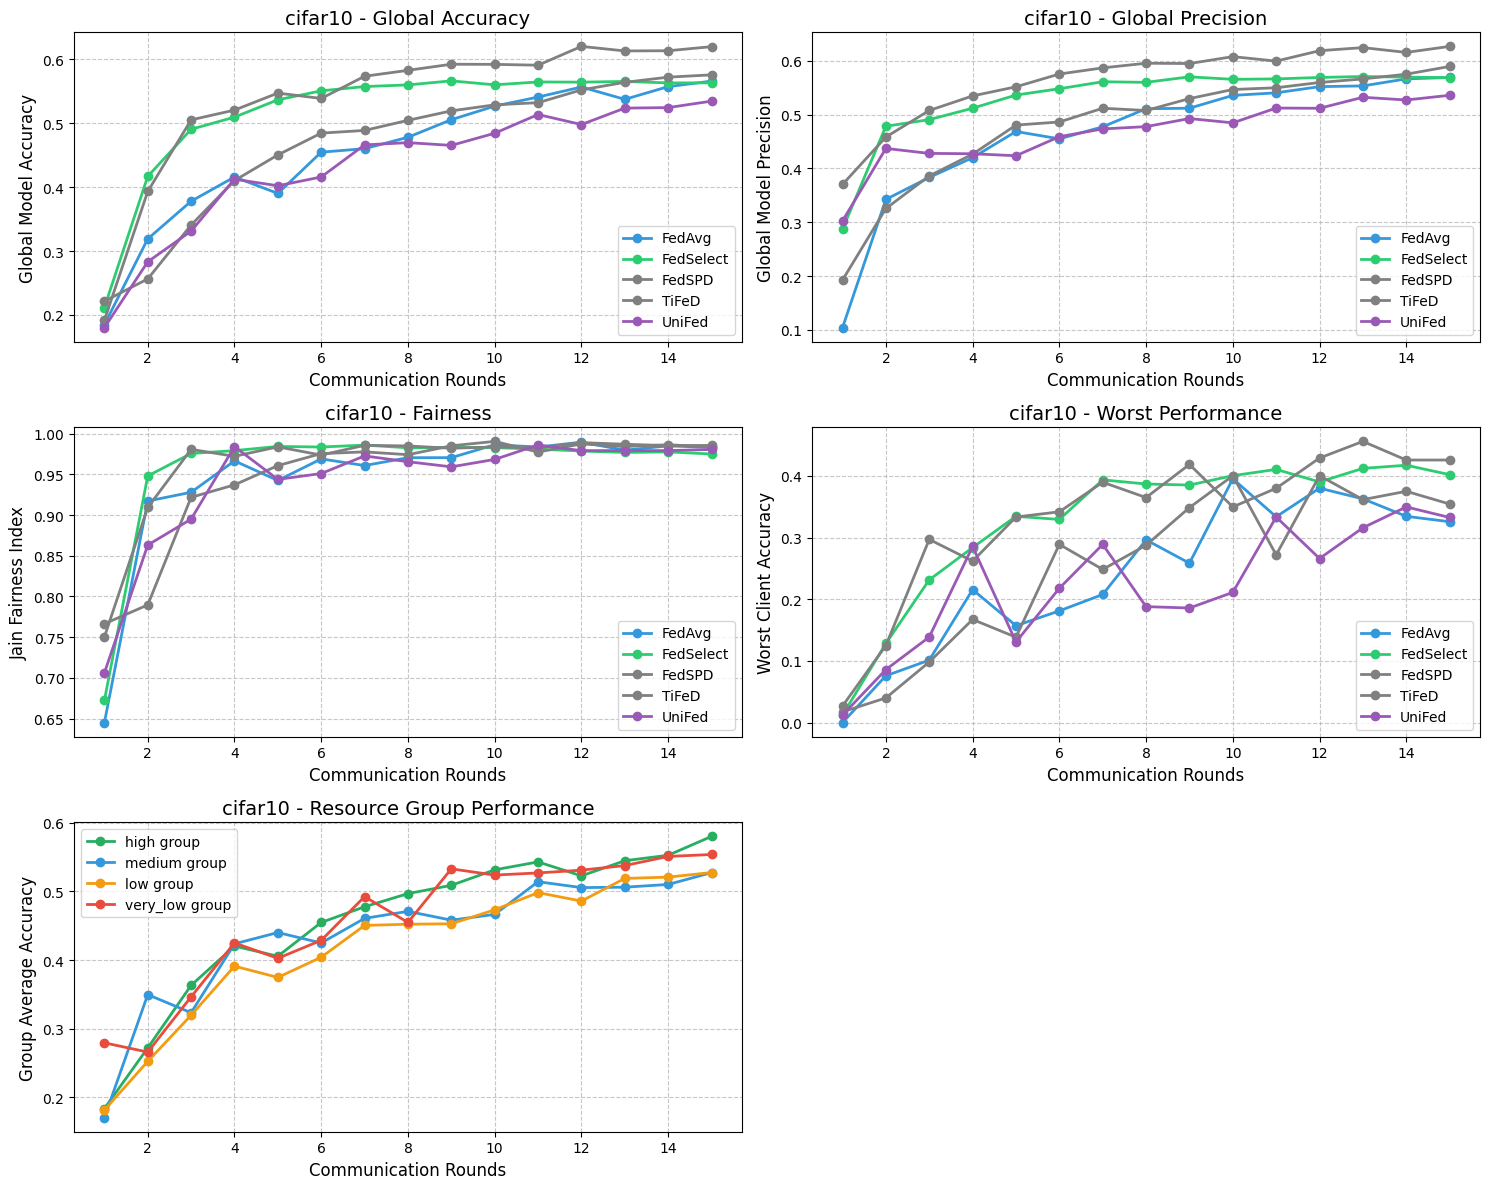

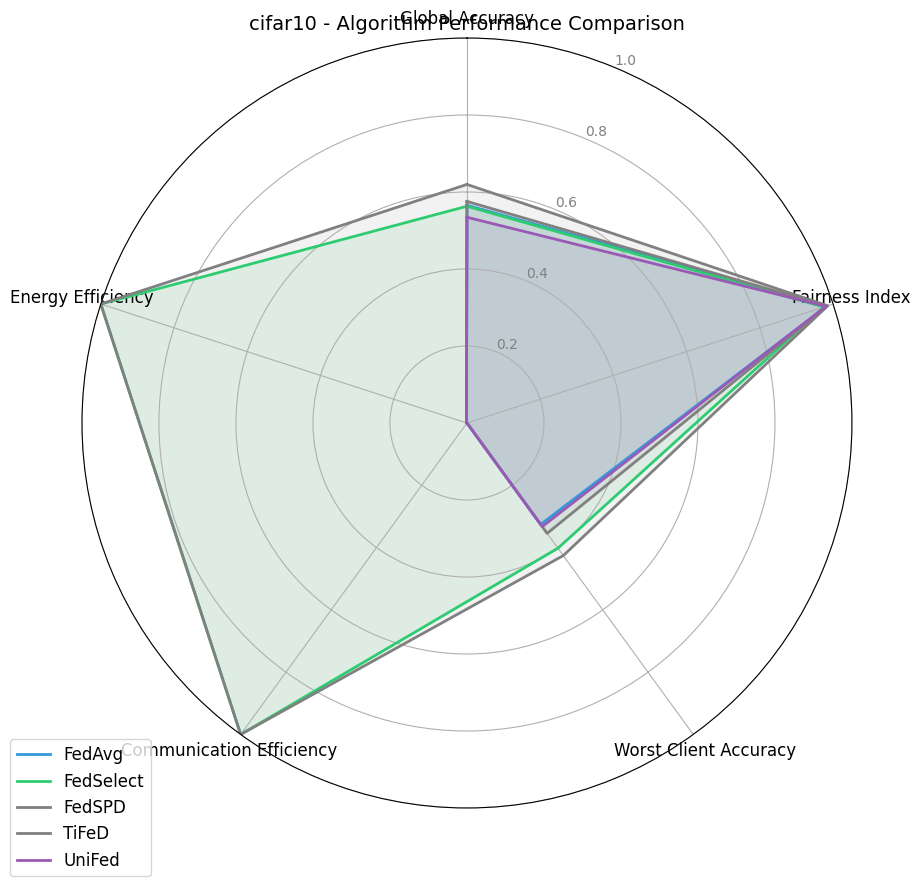

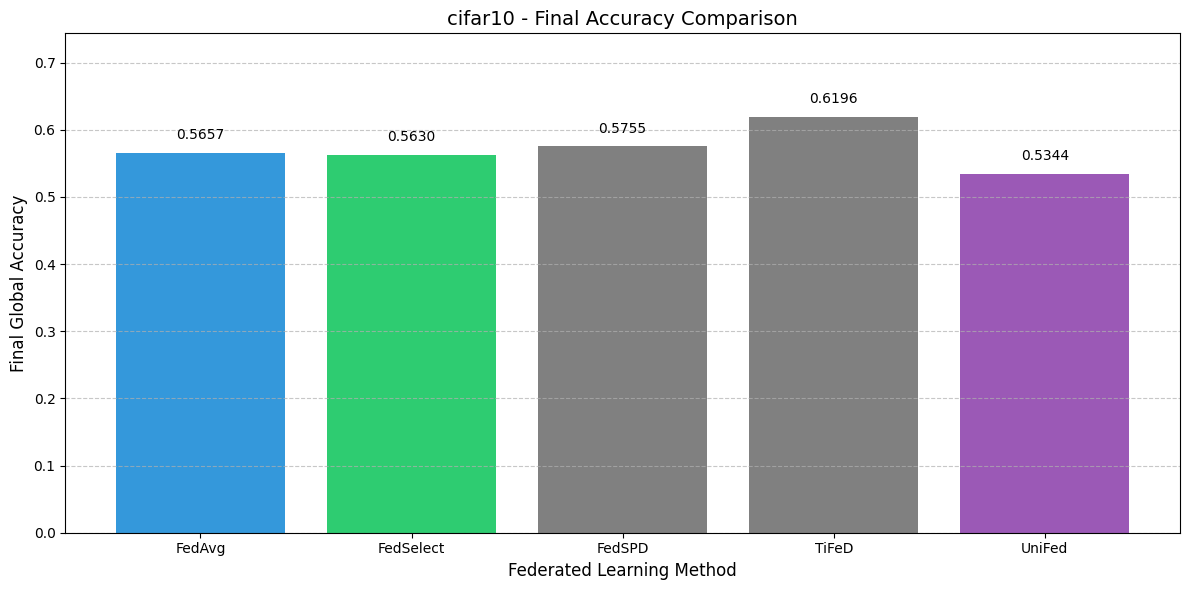

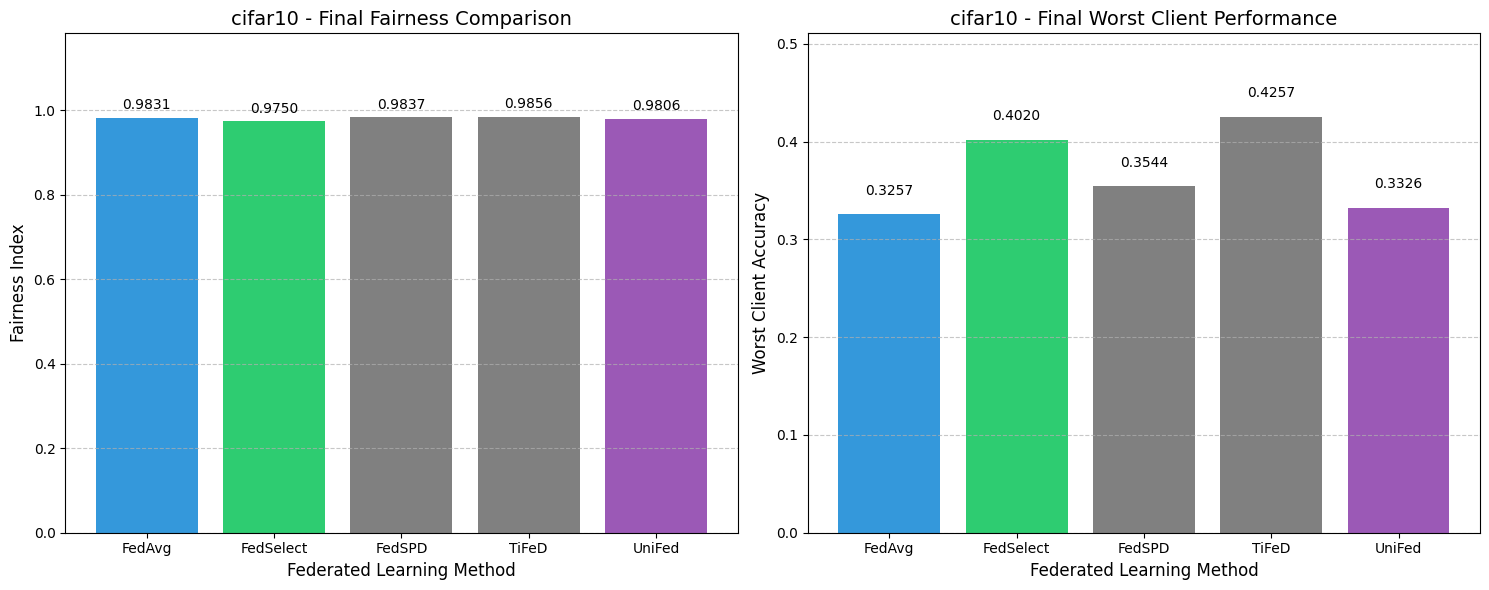

In [10]:
def main():
    # 最终比较的配置，把 mu / dfs_alpha 也一并传入
    config = {
        'dataset'          : 'cifar10',
        'num_clients'      : 100,
        'num_rounds'       : 15,
        'clients_per_round': 30,
        'num_epochs'       : 5,
        'alpha'            : 0.5,
        'mu'               : 0.005,   # FedProx & UniFed 用
        'dfs_alpha'        : 0.5,     # UniFed 用
        'methods'          : ['FedAvg', 'FedSelect', 'FedSPD', 'TiFeD', 'UniFed']
    }

    print(f"Final experiment config: {config}")

    # 这一步会依次跑 FedAvg、FedSelect、FedSPD、TiFeD、UniFed
    results = run_experiment(config)

    # 如果你还想在 main 里单独处理 results，比如打印 summary：
    for method, rounds in results.items():
        last = rounds[-1]
        print(f"\n{method} 最终表现:")
        print(f"  全局准确率: {last['global_accuracy']:.4f}")
        print(f"  全局精度  : {last.get('global_precision', last['global_accuracy']):.4f}")
        print(f"  公平性    : {last['fairness_index']:.4f}")
        print(f"  最差客户端: {last['worst_accuracy']:.4f}")

    return results

if __name__ == "__main__":
    main()
